In [1]:
#import the necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.spatial.distance as scd
import random
from itertools import compress
pd.set_option("display.max_rows", 16)
LARGE_FIGSIZE = (12, 8)


# Package to perform PCA
import sklearn.datasets
import sklearn.decomposition

In [2]:
#change directory
%cd ~/cse_601/project2/

[WinError 3] The system cannot find the path specified: 'C:\\Users\\Akash/cse_601/project2/'
C:\Users\Akash\Desktop\Clustering


In [3]:
#reading the data from file into program
file_name = "iyer.txt"
input_df = pd.read_table(file_name,header=None)
#setting the index and renaming column
input_df.rename(columns={input_df.columns[0]:'gene_id'}, inplace=True)
input_df.rename(columns={input_df.columns[1]:'gnd_truth_cluster'}, inplace=True)
input_df = input_df.set_index(input_df.columns[0])

In [4]:
# creating a copy of the input data for data processing
gdf = input_df.copy()
gdf.drop('gnd_truth_cluster', axis=1, inplace=True)

# creating lists of index and columns for reference
gene_exp_column_list = list(gdf.columns)
gene_id_list = list(gdf.index)

# creating a dataframe for storing the largest/latest cluster that each gene belongs to
gene_cluster_df = pd.DataFrame(np.nan, index=gene_id_list, columns=['cluster_assigned'])


In [5]:
# instead of dataframe for distance matrix .. using numpy array
gene_dist_np = np.zeros(shape=(len(gene_id_list), len(gene_id_list)), dtype=float)
# initializing the elements of the np array to nan
gene_dist_np.fill(np.nan)

In [6]:
# initialize dist matrx : calculate and set values in dist
def get_min_set_dist_matrix():
    for i in range(0, len(gene_id_list)):
        for j in range(i, len(gene_id_list)):
            if (not (i == j)):
                gene_dist_np[i, j] = scd.euclidean(gdf.iloc[i, :], gdf.iloc[j, :])
                gene_dist_np[j, i] = scd.euclidean(gdf.iloc[i, :], gdf.iloc[j, :])             


In [7]:
def get_idx_unassigned_pt():
    idx_unassigned_list = pd.isnull(gene_cluster_df).index.tolist()
    idx_random = random.sample(idx_unassigned_list,1)
    return idx_random[0]

In [8]:
# modifying the code to test on subsampled data
#gene_id_list = gene_cluster_df.index
gene_dist_np = np.zeros(shape=(len(gene_id_list), len(gene_id_list)), dtype=float)
# initializing the elements of the np array to nan
gene_dist_np.fill(np.nan)
get_min_set_dist_matrix()

In [9]:
#gene_dist_np

In [10]:
def regionQuery(pt , eps ):
    idx = gene_cluster_df.index.get_loc(pt)
    nhbd = set(list(compress(gene_id_list,gene_dist_np[idx]<epsilon)))
    non_assigned = set(gene_cluster_df[gene_cluster_df.cluster_assigned.isnull()].index.tolist())
    nhbd.intersection_update(non_assigned)
    return list(nhbd)

In [11]:
def dfs_expand_and_set(p_nhbd,cluster_name,eps,threshold):
    stack = p_nhbd
    while(len(stack)>0):
        pt_cur = stack.pop()
        if(gene_cluster_df.loc[pt_cur,'cluster_assigned']==cluster_name):
            pass
        else:
            #mark
            gene_cluster_df.loc[pt_cur] = cluster_name
            #print(pt_cur)
            pt_cur_nhbd = regionQuery(pt_cur,eps)
            if(len(pt_cur_nhbd)<(threshold-1)):
                pass
            else:
                #explore
                dfs_expand_and_set(pt_cur_nhbd,cluster_name,eps,threshold)

In [12]:
#gene_cluster_df[gene_cluster_df.cluster_assigned.isnull()].index.tolist()

In [13]:
#reset conditon
#gene_cluster_df['cluster_assigned']=np.nan
#print(len(gene_cluster_df[gene_cluster_df.cluster_assigned.isnull()].index.tolist()))

In [14]:
epsilon = 1
threshold = 3

In [15]:
cluster_cnt = 0
cnt=0
while(len(gene_cluster_df[gene_cluster_df.cluster_assigned.isnull()].index.tolist())>0):
    #print("unique genes left:" + str(len(gene_cluster_df[gene_cluster_df.cluster_assigned.isnull()].index.tolist())))
    gene_subset = gene_cluster_df[gene_cluster_df.cluster_assigned.isnull()].index.tolist()
    data_pt = random.sample(gene_subset,1)[0]
    data_pt_nhbd = regionQuery(data_pt,epsilon)
    if(len(data_pt_nhbd)<(threshold-1)):
        gene_cluster_df.loc[data_pt,'cluster_assigned']=0
        #print("Lone wolf:" + str(data_pt))
        pass
    else:
        c_name = "Cluster_"+str(cluster_cnt)
        c_name = cluster_cnt
        #print("Clustering for :" + c_name)
        gene_cluster_df.loc[data_pt,'cluster_assigned']=cluster_cnt
        dfs_expand_and_set(data_pt_nhbd,c_name,epsilon,threshold)
        cluster_cnt+=1
        

In [16]:
import itertools
def label_perm(x):
    idx = x-1
    return perm_list[idx]
def get_jc_label_permute(max_cluster_label_num,predicted_label,gnd_truth_vector):
    # returns final_label_pred,jc_value
    init_label = predicted_label[:]
    max_jc_value = 0
    final_label_pred = list()
    comb = itertools.permutations(range(1,max_cluster_label_num+1),max_cluster_label_num)
    #perm_list_cluster_labels = list(itertools.permutations(range(1,max_cluster_label_num+1)))
    iter_cnt = 0
    for tuple_labels in comb:
        #for tuple_labels in perm_list_cluster_labels:
        if(iter_cnt<25):
            iter_cnt+=1
            perm_cluster_label_list = list(tuple_labels)
            #pred = map(label_perm),init_label)
            pred = map((lambda x: perm_cluster_label_list[x-1]),init_label)
            js_score = jaccard_similarity_score(gnd_truth_vector,pred)
            if(js_score>max_jc_value):
                max_jc_value = js_score
                final_label_pred = pred[:]
        else:
            break
    return (max_jc_value,final_label_pred)

In [17]:
# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(gdf)

# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(gdf),
                     columns=['PCA1', 'PCA2'])
df_2D['clusters'] = gene_cluster_df['cluster_assigned']
df_2D.head()

,PCA1,PCA2,clusters
0,2.204508,-1.202431,NaN
1,1.552872,-0.738508,0.0
2,1.546893,-1.082992,0.0
3,1.798502,-1.115309,0.0
4,1.568234,-0.959787,0.0


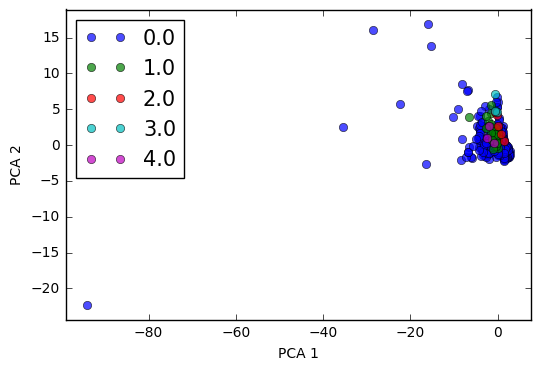

In [18]:
for key, group in df_2D.groupby(['clusters']):
    plt.plot(group.PCA1, group.PCA2, 'o', alpha=0.7, label=key)

# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [19]:
from sklearn.metrics import jaccard_similarity_score
gnd_truth_np = np.array(input_df.loc[:,'gnd_truth_cluster'],dtype=int)
pred = gene_cluster_df['cluster_assigned']
js_score = jaccard_similarity_score(gnd_truth_np,pred)
#j_score,pred_label_map = get_jc_label_permute(max_cluster_label_num = 5,predicted_label=np.array(pred) ,gnd_truth_vector= gnd_truth_np)

In [20]:
js_score

0.0

In [21]:
gene_cluster_df.cluster_assigned.tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [22]:
setA = set(gene_cluster_df.cluster_assigned.tolist())

In [23]:
setA

{0.0, 1.0, 2.0, 3.0, 4.0}

In [24]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [25]:
epsilon = 1.1
threshold = 4

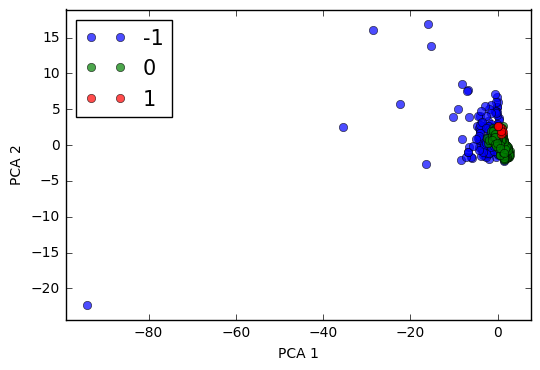

In [26]:
db = DBSCAN(eps=epsilon, min_samples=threshold,metric='euclidean').fit(gdf)
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(gdf)

# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(gdf),
                     columns=['PCA1', 'PCA2'])
df_2D['clusters'] = list(labels)

for key, group in df_2D.groupby(['clusters']):
    plt.plot(group.PCA1, group.PCA2, 'o', alpha=0.7, label=key)

# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')